# Gilbert Crew: Final Studio Analysis

### Analysis Introduction: 

Our group was tasked with diving into multiple data sets to provide analysis for Computing Vision, a company looking to get started with creating original video content. Our team combed through datasets from IMDB, Rotten Tomatoes, MOJO, and The Numbers to come up with three recommendations for Computing Vision based on various metrics. 

Some metrics we dive into include but are not limited to: 
* Movie Ratings/Popularity
* Net Income
* Movie Genre
* Movie Runtime
* Team Personel 

These metrics were selected because we believe they provide a helpful insight into creating the best possible studio and present guidlines on movie creation that will ultimately drive value for Computing Vision.

First, we will start our analysis by importing packages, and loading data needed for our analysis. 

In [1]:
#Importing neccesary packages
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning, )
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from math import sqrt

In [2]:
#Loaded in relevant files from IMDB for main analysis
directors_file = "files/imbd_files/directors.csv"
known_for_file= "files/imbd_files/known_for.csv"
movie_akas_file = "files/imbd_files/movie_akas.csv"
movie_basics_file = "files/imbd_files/movie_basics.csv"
movie_ratings_file= "files/imbd_files/movie_ratings.csv"
persons_file = "files/imbd_files/persons.csv"
principals_file= "files/imbd_files/principals.csv"
writers_file = "files/imbd_files/writers.csv"
#Read files into dataframes
directors = pd.read_csv(directors_file)
known_for = pd.read_csv(known_for_file)
movie_akas = pd.read_csv(movie_akas_file)
movie_basics = pd.read_csv(movie_basics_file)
movie_ratings = pd.read_csv(movie_ratings_file)
persons = pd.read_csv(persons_file)
persons = persons[persons.death_year.isnull()]
principals = pd.read_csv(principals_file)
writers = pd.read_csv(writers_file)
# Read in Data For Revenue Section
budgets = pd.read_csv('Files/tn.movie_budgets.csv.gz')

Setting up budget variable to be used in future analysis. We start by taking out the dollar signs and commas from the production budget, worldwide gross, and domestic gross and converting the column values from objects to floats to analyze.

In [3]:
budgets['production_budget'] = budgets['production_budget'].str.replace('$','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace('$','')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace('$','')
budgets['production_budget'] = budgets['production_budget'].str.replace(',','')
budgets['domestic_gross'] = budgets['domestic_gross'].str.replace(',','')
budgets['worldwide_gross'] = budgets['worldwide_gross'].str.replace(',','')
budgets = budgets.drop(columns=['id', 'release_date'])
#Rename movie row to primary_title for consistency with previous tables
budgets = budgets.rename(columns={'movie': 'primary_title'})
budgets['production_budget'] = budgets['production_budget'].astype(float)
budgets['domestic_gross'] = budgets['domestic_gross'].astype(float)
budgets['worldwide_gross'] = budgets['worldwide_gross'].astype(float)

Now that we have our column values into floats, we can create a net revenue column.

In [4]:
net = budgets.worldwide_gross - budgets.production_budget
budgets['net_revenue'] = net

## Recommendation #1: Movie Length

In this section we used statistical analysis to find out if there was correlation between movie length (minutes) and the top 100 best rated movies by rating.

We wanted to see if the difference in means between our sample of top rated movies and the population of movies on IMDB was significant so we decided to use a 1 tail T-test. 

To further our analysis, we also conducted a similar test by the top 100 net earning films as well.

### Code:

First, we needed to cleanup the data and merge movie_basics with movie_ratings to display the movie rating, and runtime metrics.

In [5]:
#Merged movie ratings with movie basics
movie_info = pd.merge(movie_basics, movie_ratings, how="inner", on='movie_id')

We then created the 'movies' and 'top_100_movies' variables to use in our analysis.

In [6]:
#Movies sort by most votes and avereage rating
top_movies = movie_info.sort_values(by=['numvotes', 'averagerating'], ascending=False)
#Top 100 movies selected
top_100_movies_pop = top_movies.iloc[:100]
#Top 100 movies sorted specifically by movie rating
top_100_movies_pop = top_100_movies_pop.sort_values(by='averagerating', ascending=False)
#Index reseted for top 100 movies
top_100_movies_pop = top_100_movies_pop.reset_index().drop(columns='index')
#Select columns renamed for consistency among columns
top_100_movies_pop = top_100_movies_pop.rename(columns={'numvotes': 'num_votes', 'averagerating': 'avg_rating'})

#Adding a new variable 'movies' to manipulate
movies = top_movies.sort_values(by='averagerating', ascending=False)
movies = top_movies.reset_index().drop(columns='index')
movies = top_movies.rename(columns={'numvotes': 'num_votes', 'averagerating': 'avg_rating'})
movies.drop(labels=['primary_title', 'original_title', 'start_year', 'movie_id', 'genres', 'num_votes'], axis=1);
movies.isnull().sum()

movie_id              0
primary_title         0
original_title        0
start_year            0
runtime_minutes    7620
genres              804
avg_rating            0
num_votes             0
dtype: int64

From here, we know that the information we want to look at contains Null values. Because of this, we must clean the data for proper analysis. There are few factors for how we proceeded:

* We decided to drop the Null values in 'runtime_minutes' 
* If we replaced 'NaN' with the average our analysis would be similar but not truthful of actual runtime
* Used dropna to remove data

In [7]:
#Dropping 'Null' values
movies.dropna(axis=0, subset=['runtime_minutes'], inplace=True)

In [8]:
#Creates df with just the data we need
cleaned_movies = movies['runtime_minutes']

In order to make meaningful use of our data we needed to get rid of outliers. For example, one movie in the set was 5,000 minutes long and severely affected some results. We decided to use 99% of our data and set our percentiles to reflect all data between the bottom 1% and the top 99% to relfect a more accurate depiction of the movie population on IMDB. 

In [9]:
#Getting rid of outliers 
np.percentile(cleaned_movies, [1, 50, 99.4])
good_data = cleaned_movies[(cleaned_movies < 170) & (cleaned_movies > 45)]

Below, we supplied a graph that refelcts our analysis and shows the mean differences between the two sets of data.

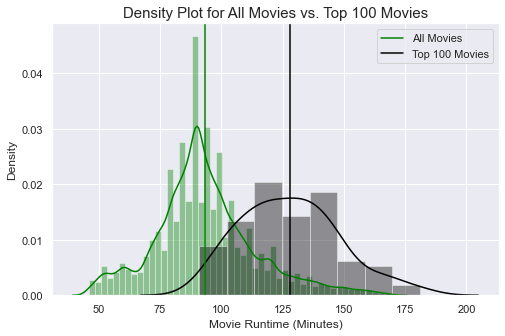

In [10]:
#Plotting all movies vs top 100 based on runtime
sns.color_palette("light:#5A9", as_cmap=True)
runcolor =top_100_movies_pop['runtime_minutes']
sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(8,5)})
sns.distplot(good_data, color='Green')
sns.distplot(top_100_movies_pop['runtime_minutes'], color='Black')#31a354
plt.xlabel("Movie Runtime (Minutes)", size=12)
plt.title("Density Plot for All Movies vs. Top 100 Movies", size=15)
plt.axvline(x=good_data.mean(), color='Green')
plt.axvline(x=runcolor.mean(), color='Black')
plt.legend(labels=(['All Movies','Top 100 Movies']));

Statistical test:

* Determined that one tail t-test would be the most beneficial
* Testing to see if the top 100 movies runtime is statistically significant

Null and Alternative Hypothesis:

* Top rated movies have the same runtime as all other movies on IMDB (null)
* Top rated movies do have a longer runtime than all other movies on IMBD (alternative)


Setting up variables for the T-Test:

In [11]:
sd = np.std(top_100_movies_pop['runtime_minutes'], ddof=1)
mu = cleaned_movies.mean()
x_bar = top_100_movies_pop['runtime_minutes'].mean()
n = 100
df = 99
alpha= 0.05
print('The standard deviation of the sample =', sd)
print('The mean of the population =', mu)
print('The mean of the sample is =', x_bar)
print('The number of observations is =', n)

The standard deviation of the sample = 20.002270073189397
The mean of the population = 94.6540400990398
The mean of the sample is = 127.99
The number of observations is = 100


Plotting the T-statistic, and critical Tvalue to show our T-test in graphical form. This test is performed to test our  hypothesis.

The T-Statistic is = 16.666088288470306
The critical T value is = 1.6603911559963895
We reject the Null hypothesis because our T statistic is in the reject zone!


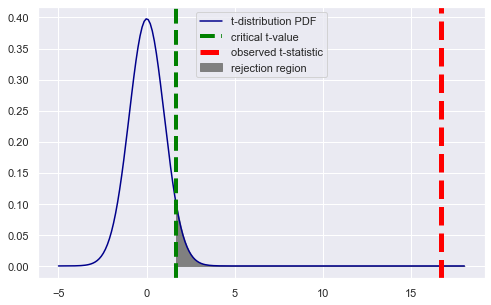

In [12]:
t_stat= (x_bar -  mu)/(sd/np.sqrt(n))
t_crit = st.t.ppf(1 - 0.05, df=99)
print('The T-Statistic is =', t_stat)
print('The critical T value is =', t_crit)
if t_stat <= t_crit:
    print('We fail to reject the Null hypothesis because our T statistic is less than the citical T value.')
else: 
    print('We reject the Null hypothesis because our T statistic is in the reject zone!')
    
fig, ax = plt.subplots(figsize=(8,5))

x = np.linspace(-5, 18, 200)
y = st.t.pdf(x, df, 0, 1)

ax.plot(x, y, color='darkblue', label="t-distribution PDF")
ax.axvline(t_crit,color='green',linestyle='--',lw=4,label='critical t-value')
ax.fill_betweenx(y,x,t_crit,where=x > t_crit,color="gray",label="rejection region")
ax.axvline(t_stat, color='Red', linestyle='--', lw=5,label='observed t-statistic')

ax.legend();

Next we test to make sure info is plotted correctly by our alpha of .05 and confirming results by finding the P-Value.

In [13]:
#Shows that our alpha of .05 is correct
st.t.cdf(t_crit, df=99)

0.9499999999979238

In [14]:
#Re-affirms findings that we reject Null
p_value = st.t.sf(t_stat, df=99)
p_value

8.619752364999059e-31

Our findings indicate that there is a correlation between movie run time and movie ratings. If Computing Vision can get there runtime to around 127 minutes reviews are likely to be better! Next, the following code will show if the highest net earning films have a similar result with respect to runtime.

In [15]:
second_suggestion = pd.merge(movie_info, budgets, how="inner", on='primary_title')
second_suggestion.isnull().sum()

movie_id               0
primary_title          0
original_title         0
start_year             0
runtime_minutes      118
genres                 8
averagerating          0
numvotes               0
production_budget      0
domestic_gross         0
worldwide_gross        0
net_revenue            0
dtype: int64

This data also has null values so we will remove them due to the same reasons as previously mentioned.

In [16]:
second_suggestion.dropna(axis=0, inplace=True)
top_100_rev = second_suggestion.sort_values(by='net_revenue',axis=0, ascending=False).iloc[:100]
top_100_runtime = top_100_rev['runtime_minutes']
rev_movies = second_suggestion['runtime_minutes']

Statistical test:

* Determined that one tail t-test would be the most beneficial
* Testing to see if the top 100 movies runtime is statistically significant

Null and Alt Hypothesis:

* The top net earning movies have the same runtime as all other movies on The Numbers Dataset (null)
* The top net earning movies do have a longer runtime than all other movies on The Numbers Dataset (alternative)

Used a graph to plot the differeces between our two new data sets.

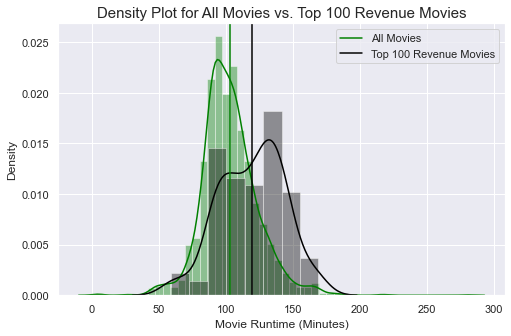

In [17]:
sns.distplot(rev_movies, color='Green')
sns.distplot(top_100_runtime, color='Black')
plt.xlabel("Movie Runtime (Minutes)", size=12)
plt.title("Density Plot for All Movies vs. Top 100 Revenue Movies", size=15)
plt.axvline(x=top_100_runtime.mean(), color='Black')
plt.axvline(x=rev_movies.mean(), color='Green')
plt.legend(labels=(['All Movies','Top 100 Revenue Movies']));

Next we run a T-test similar to our previous one. These variables are used to calculate the T-statistic and critical T-value.

In [18]:
sd = np.std(top_100_runtime, ddof=1)
mu = rev_movies.mean()
x_bar = top_100_runtime.mean()
n = 100
df = 99
alpha= 0.05
print('The standard deviation of the sample =', sd)
print('The mean of the population =', mu)
print('The mean of the sample is =', x_bar)
print('The number of observations is =', n)

The standard deviation of the sample = 24.012225421584102
The mean of the population = 102.9720203488372
The mean of the sample is = 119.33
The number of observations is = 100


Here we calculate the T-statistic and critical T-value and plot graphically.

The T-Statistic is = 6.8123546918141695
The critical T value is = 1.6603911559963895
We reject the Null hypothesis because our T statistic is in the reject zone!


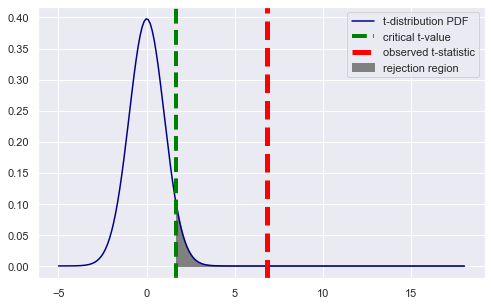

In [19]:
t_stat= (x_bar -  mu)/(sd/np.sqrt(n))
t_crit = st.t.ppf(1 - 0.05, df=99)
print('The T-Statistic is =', t_stat)
print('The critical T value is =', t_crit)
if t_stat <= t_crit:
    print('We fail to reject the Null hypothesis because our T statistic is less than the citical T value.')
else: 
    print('We reject the Null hypothesis because our T statistic is in the reject zone!')
    
fig, ax = plt.subplots(figsize=(8,5))

x = np.linspace(-5, 18, 200)
y = st.t.pdf(x, df, 0, 1)

ax.plot(x, y, color='darkblue', label="t-distribution PDF")
ax.axvline(t_crit,color='green',linestyle='--',lw=4,label='critical t-value')
ax.fill_betweenx(y,x,t_crit,where=x > t_crit,color="gray",label="rejection region")
ax.axvline(t_stat, color='Red', linestyle='--', lw=5,label='observed t-statistic')

ax.legend();

This graph represents the T-test of our hypothesis and concludes that we must reject the null. This means that the top net earning movies do have a longer runtime than all other movies on 'The Numbers' Dataset.

### Conclusion for Recommendation #1:

Computing Vision should strive to have movie runtime between 119 - 130 minutes to increase net revenue and ratings for its upcoming film catalog. Based on our analysis using statistics, we can conclude that the top films by revenue as well as by rating have a significant correlation with movie run time. We recommend that Computing Vision keep this time frame in mind when creating new films.

## Recommendation #2: Genre Type

In this section we used data analysis to find out if there was difference in genre type based on the top 100 most profitable and highly rated movies overall. We will do this by taking all of the genres classified to each movie and counting them.

We want to see if the difference would affect which types of movie genre(s) Computing Vision should pursue for their new movie studio. Picking a highly profitable and popular genre can help build a brand reputation for the movie studio.

In [20]:
#Merge movie ratings with movie basics to look at the coorelation with rating and genre
movie_rating_info = pd.merge(movie_basics, movie_ratings, how="inner", on='movie_id')
movie_rating_info.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


We pulled the top 100 movies variable from earlier in our analysis.

We then split our genre column so that the genres are seperated to be able to count the number of times each genre occurs in the top 100 movies.

In [21]:
#Declaring new variable to split genre data into separate columns
pop_string_split = top_100_movies_pop
#Splitting genre values into new columns
pop_genre_split = pop_string_split["genres"].str.split(",", n = 3, expand = True)
#Concatinated genre columns into 1 series
top_100_pop_genres = pd.concat([pop_genre_split[0], pop_genre_split[1], pop_genre_split[2]])
#Dropna from genre series
top_100_pop_genres = top_100_pop_genres.dropna()
#Counting genre counts in top 100 movie list
top_100_pop_genre_counts = top_100_pop_genres.value_counts()

This information helps lead our recommendation to conclude which genres to purse and which to avoid. From this graph, we know that the highest rated movie genre is Adventure, followed closely by Action. A possible recommendation could be to avoid creating movies in the genres Western, Sport, Horror, and Music.

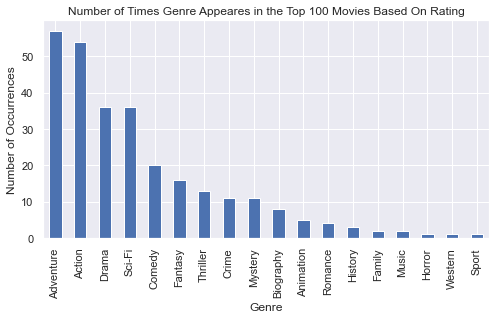

In [22]:
#Bar plot of top 100 genre counts based on popularity
top_100_pop_genre_counts.plot(kind='bar', figsize=(8, 4), 
                             title='Number of Times Genre Appeares in the Top 100 Movies Based On Rating')
plt.xlabel('Genre')
plt.ylabel('Number of Occurrences');

We will now also do this analysis of genres based of the top 100 highest revenue movies. Previously, we read in and cleaned the budgets table and can now use it for this analysis.

Since the net revenue column is already created, we will merge the movie basics table in with our budgets table to look at the genres compared to revenue.

In [23]:
#Merge movie basics with budget
movie_revenue_info = pd.merge(movie_basics, budgets, how="inner", on='primary_title')
movie_revenue_info.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,production_budget,domestic_gross,worldwide_gross,net_revenue
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",45000000.0,0.0,73706.0,-44926294.0
1,tt0293429,Mortal Kombat,Mortal Kombat,2021,NaN,"Action,Adventure,Fantasy",20000000.0,70433227.0,122133227.0,102133227.0
2,tt0326592,The Overnight,The Overnight,2010,88.0,NaN,200000.0,1109808.0,1165996.0,965996.0
3,tt3844362,The Overnight,The Overnight,2015,79.0,"Comedy,Mystery",200000.0,1109808.0,1165996.0,965996.0
4,tt0337692,On the Road,On the Road,2012,124.0,"Adventure,Drama,Romance",25000000.0,720828.0,9313302.0,-15686698.0


In [24]:
#Drop Duplicate Titles
movie_revenue_info = movie_revenue_info.drop_duplicates(subset=['primary_title'])

We start this analysis by taking the top 100 movies based on rating.

In [25]:
#Movies sorted by net revenue
revenue_sorted = movie_revenue_info.sort_values(by='net_revenue', ascending=False)
#Top 100 movies selected
top_100_rev = revenue_sorted.iloc[:100]
#Top 100 movies sorted specifically by movie rating
top_100_rev = top_100_rev.reset_index().drop(columns='index')

We then split our genre column so that the genres are seperated to be able to count the number of times each genre occurs in the top 100 movies.

In [26]:
#Declaring new variable to split genre data into separate columns
string_split_rev = top_100_rev
#Splitting genre values into new columns
genre_split_rev = string_split_rev["genres"].str.split(",", n = 3, expand = True)
#Concatinated genre columns into 1 series
top_100_rev_genres = pd.concat([genre_split_rev[0], genre_split_rev[1], genre_split_rev[2]])
#Drop na from genre series
top_100_rev_genres = top_100_rev_genres.dropna()
#Counting genre counts in top 100 movie list
top_100_rev_genre_counts = top_100_rev_genres.value_counts()

Once again, this graph shows us that the highest grossing movie genre is Adventure, followed closely by Action. 

We are able to verify our first possible recommendation of avoiding movies in the genres Western, Sport, Horror, and Music.

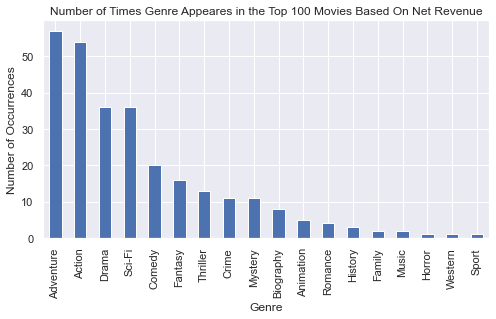

In [27]:
#Bar plot of top 100 genre counts based on Net Revenue
top_100_pop_genre_counts.plot(kind='bar', figsize=(8, 4),
                             title='Number of Times Genre Appeares in the Top 100 Movies Based On Net Revenue')
plt.xlabel('Genre')
plt.ylabel('Number of Occurrences');

Although the top two are the same, the count for each is different, and the genres following are in a different order. To understand this, we will add the two findings together and create a new data visualization.

In [28]:
#Concatenate the two results together
movie_genres = pd.concat([top_100_rev_genre_counts, top_100_pop_genre_counts], axis=1)
#Change all null values to zero to represent that there are none in the top 100 movies in that category
movie_genres = movie_genres.fillna(0)
#Renaming the column names to reflect which came from the rating results and the revenue results
movie_genres.rename(columns= {0 : 'Revenue', 1 : 'Rating'}, inplace=True)

This graph gives us a side by side comparison between the number of times a genre occurs based off of revenue and rating.

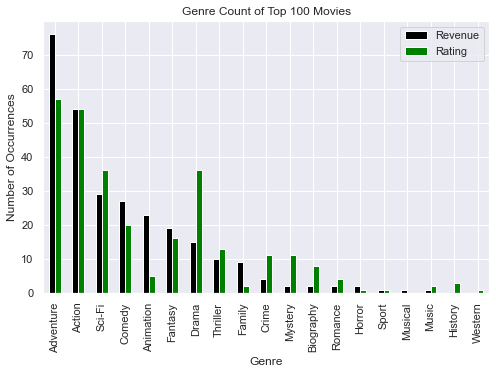

In [29]:
#Plot the count of revenue and rating in each genre side by side to see which genres are the most popular and most profitable
movie_genres.plot(kind='bar', title='Genre Count of Top 100 Movies', color = ['Black','Green'])
plt.xlabel('Genre')
plt.ylabel('Number of Occurrences');

### Conclusion for Recommendation #2:
This graph confirms that although the two graphs looked similar standing alone, when combined, they are visually different. We can use this information to recommend that Computing Vision should not create moives in the genres Western, Sport, Music, and History. 

## Recommendation #3: Principal Directors, Writers and Actors

The primary goal of this section was to determine which Principal Director, Writer, and Actor would be most benificial for Computing Vision to pursue in order to produce films that are succesful in terms of both profitability and ratings.

This was acheived by analyzing the top 100 movies based on rating as well as net revenue to determine which principal directors, writers, and actors were involved to help make these movies a success.

### Count Directors in the Top 100 Movies

In this section we obtain all the directors that directed the top 100 moves, both in the top 100 rated movies and top 100 based on net revenue. 

We start by first merging the director information with the top 100 rated movies and count how many times each director appears.

In [30]:
# merge movie directors with top 100 movies based on Rating
top_pop_dir = pd.merge(top_100_movies_pop, directors, how="inner", on='movie_id')
# merge persons table with top movie directors to get director names
top_pop_dir = pd.merge(top_pop_dir, persons, how="inner", on='person_id')
# drop duplicate movies
top_pop_dir.drop_duplicates(subset=['movie_id'], inplace=True)
# Count number of times director appears in the top 100 movies based on ratings
top_pop_director_counts = top_pop_dir.primary_name.value_counts()
top_pop_director_counts.sort_values(ascending=False, inplace=True)

We then merge the director information with the top 100 movies based on revenue and count how many times each director appears.

In [31]:
# Merge top 100 movies based on revenue and directors into one dataframe, 
top_100_dir = pd.merge(top_100_rev, directors, how='inner', on='movie_id')
# merge persons table with top movie directors to get director names
top_100_dir = pd.merge(top_100_dir, persons, how='inner', on='person_id')
# drop duplicate movies
top_100_dir.drop_duplicates(subset=['movie_id'], inplace=True)
# Count number of times director appears in the top 100 movies based on ratings and select top 25 results
top_rev_dir_counts = top_100_dir.primary_name.value_counts()
top_rev_dir_counts.sort_values(ascending=False, inplace=True)

We are now able to merge both results into a dataframe to create a visualization.

In [32]:
#Merge director counts in from top 100 rated movies with director counts in top 100 movies based on revenue
top_rev_dir_df = top_rev_dir_counts.to_frame()
top_pop_dir_df = top_pop_director_counts.to_frame()
top_director_counts = pd.merge(top_pop_dir_df, top_rev_dir_df, how="outer", left_index=True, right_index=True)

#Change all null values to zero (zero counts)
top_director_counts = top_director_counts.fillna(0)
# Reset Index for easier plotting
top_director_counts.reset_index(inplace=True)
#Rename columns to clearly represent the data
top_director_counts.rename(columns= {'index': 'Directors', 'primary_name_x' :'Top 100 Movies Based on Rating', 'primary_name_y' :'Top 100 Movies Based on Net Revenue'}, inplace=True)
#Sort the values on both columns in descending order
top_director_counts.sort_values(by=['Top 100 Movies Based on Rating'] , ascending=False, inplace=True)

In [33]:
top_director_counts

,Directors,Top 100 Movies Based on Rating,Top 100 Movies Based on Net Revenue
25,Christopher Nolan,4.0,3.0
8,Anthony Russo,4.0,3.0
76,Matthew Vaughn,3.0,0.0
86,Peter Jackson,3.0,3.0
65,Joss Whedon,2.0,2.0
...,...,...,...
69,Kyle Lawrence,0.0,1.0
75,Matt Reeves,0.0,1.0
77,Michael Bay,0.0,2.0
78,Mike Mitchell,0.0,1.0


### Number of Times Directors Appears in the Top 100 Movies
Here we create a visualization to easily see the number of times each director appears in the top 100 movies based off of ratings as well as the top 100 movies based on net revenue. We can also compare how they are differint.

C:\Users\chrchristensen\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1373: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.bar(x, y, w, bottom=start, log=log, **kwds)


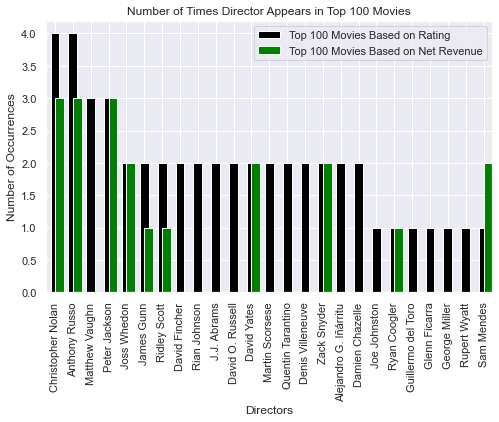

In [34]:
#Plot the count of revenue and rating for each director
top_director_counts.iloc[:25].plot(kind='bar', 
                                   x='Directors', 
                                   title='Number of Times Director Appears in Top 100 Movies', 
                                   color = ['Black','Green'],
                                   alpha=1,
                                   figsize=(8, 5),
                                   Width=.5,
                                   ylabel='Number of Occurrences',
                                   xlabel='Directors');

From this visual, we can clearly see which directors directed the most movies in the top 100 movies based on both rating and net revenue. It would therefore be highly recomended to choose directors that appear in this list when at all possible. Especially those that appear in both the top 100 rated movies and the top 100 movies based on net revenue.

### Net Revenue  Per Movie Associated with Each Director

Now that we know which directors directed the most movies in top 100. It would also be valuable to know which directors ranked highest by the total net revenue Per Movie in the top 100.

We can acheive this by grouping the revenue data by director and summing the net revenue for each director, and merging it with the director count in the top 100. 

In [35]:
# Net Revenue per Movie Associated With Each Director in the top 100 Movies
top_dir_groupby = top_100_dir.groupby('primary_name').sum().sort_values(by='net_revenue', ascending=False)
top_dir_groupby['ratio'] = 0
top_dir_groupby.reset_index(inplace=True)
top_dir = top_dir_groupby.rename(columns={'primary_name': 'Directors'})
director_ratio = pd.merge(top_dir, top_director_counts, how='inner', on='Directors')
director_ratio = director_ratio[director_ratio['Top 100 Movies Based on Rating'] != 0]

We then create a new ratio column that is the ratio of net revenue per number of movies associated with the director in the top 100 movies.

In [36]:
#Ratio of net revenue per movie in the top 100 movies
director_ratio.ratio = director_ratio.net_revenue/director_ratio['Top 100 Movies Based on Rating']
# # Sorting in descending order
director_ratio.sort_values(by='ratio', inplace=True, ascending = False)

We can now visualize the results of the ratio column using a bar graph in descending order.

C:\Users\chrchristensen\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1373: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.bar(x, y, w, bottom=start, log=log, **kwds)


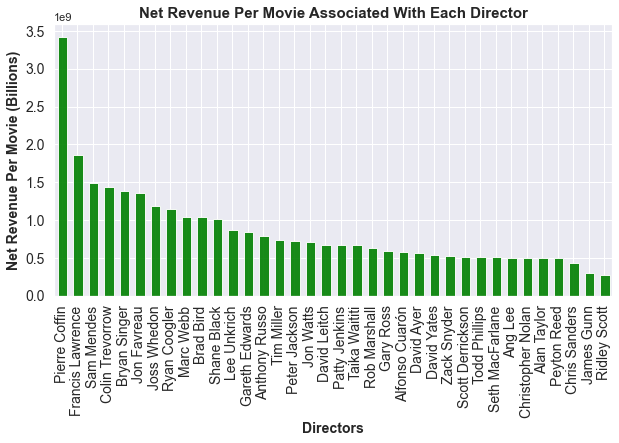

In [37]:
#Bar plot of the Ratio of net revenue per movie in the top 100 movies
director_ratio.plot(kind='bar',  
                    figsize=(10, 5), 
                    color='Green', 
                    alpha=.9,
                    Width=.6,
                    fontsize=14,
                    x='Directors',
                    y='ratio',
                    legend=False)
plt.title('Net Revenue Per Movie Associated With Each Director', fontsize=15, fontweight='bold')
plt.xlabel('Directors', fontsize=14, fontweight='bold')
plt.ylabel('Net Revenue Per Movie (Billions)', fontsize=14, fontweight='bold');

We can now easily visualize the amount of net revenue per movie that is associated with each director in the top 100 movies. This is valuable because if we used the sum associated with each director for the total movies in the top 100, they are often  movies that are involved in the longest franchise. This levels the playing ground for those directors that were not in a long popular franchise. The top suggested choices for directors are: Pierre Coffin, Francis Lawrence, and Sam Mendes.

### Writers In Top 100 Movies
In this section we repeat the process above except we obtain all the writers for the top 100 movies.

The data preparation here is identical to that which was performed above except we join the writer information to perform our analysis.

In [38]:
# merge movie writers with top 100 Rated Movies
top_writers = pd.merge(top_100_movies_pop, writers, how="inner", on='movie_id')
# merge persons with top movie directors to get director names
top_writers = pd.merge(top_writers, persons, how="inner", on='person_id')
# drop duplicate movies
top_writers.drop_duplicates(subset=['movie_id'], inplace=True)
# count of writers in top 100 rated movies and select top 25
top_pop_writer_counts = top_writers.primary_name.value_counts()
top_pop_writer_counts.sort_values(ascending=False, inplace=True)

# Merge Top 100 movies based on Revenue and writers into one dataframe, 
top_100_writers = pd.merge(top_100_rev, writers, how='inner', on='movie_id')
# merge persons with top movie directors to get director names
top_100_writers = pd.merge(top_100_writers, persons, how='inner', on='person_id')
# drop duplicate movies
top_100_writers.drop_duplicates(subset=['movie_id'], inplace=True)
# Count writers in top 100 moveis based on revenue
top_rev_writer_counts = top_100_writers.primary_name.value_counts()
top_rev_writer_counts.sort_values(ascending=False, inplace=True)

# Group 100 top movies based on revenue by writer to get sum net revenue per writer
top_writer_groupby = top_100_writers.groupby('primary_name').sum().sort_values(by='net_revenue', ascending=False)
# Select only top 25
top_writer_groupby = top_writer_groupby.net_revenue

#create dataframes of writer counts in top 100 moves and merge them together
top_rev_writer_df = top_rev_writer_counts.to_frame()
top_pop_writer_df = top_pop_writer_counts.to_frame()
top_writer_counts = pd.merge(top_pop_writer_df, top_rev_writer_df, how="outer", left_index=True, right_index=True)
#Change all null values to zero to represent that there are none in the top 100 movies in that category
top_writer_counts = top_writer_counts.fillna(0)
# Reset Index for easier plotting
top_writer_counts.reset_index(inplace=True)
#Rename the columns to more clearly reflect data
top_writer_counts.rename(columns= {'index': 'Writers', 'primary_name_x' :'Top 100 Movies Based on Rating', 'primary_name_y' :'Top 100 Movies Based on Net Revenue'}, inplace=True)
# Sort values in descending order
top_writer_counts.sort_values(by=['Top 100 Movies Based on Rating'] , ascending=False, inplace=True)

### Number of Times Writers Appear in the Top 100 Movies
We again create a bar graph to easily visualize the writers that appear in both the top 100 rated movies and the top 100 based on net revenue.

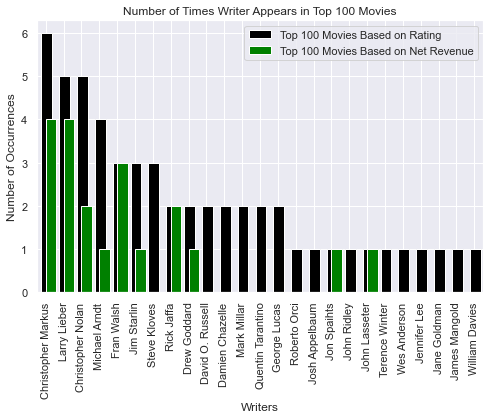

In [39]:
#Plot the count of revenue and rating for each writer in top 100 movies
top_writer_counts.head(25).plot(kind='bar', 
                       x='Writers', 
                       title='Number of Times Writer Appears in Top 100 Movies', 
                       color = ['Black','Green'],
                       alpha=1,
                       figsize=(8, 5),
                       Width=.6,
                       ylabel='Number of Occurrences',
                       xlabel='Writers');

### Net Revenue  Per Movie Associated with Each Writer

In [40]:
top_writer = top_writer_groupby.to_frame()
top_writer['ratio'] = 0
top_writer.reset_index(inplace=True)
top_writers = top_writer.rename(columns={'primary_name': 'Writers'})
writer_ratio = pd.merge(top_writers, top_writer_counts, how='inner', on='Writers')

#Ratio of net revenue per movie in the top 100 movies
writer_ratio.ratio = writer_ratio.net_revenue/writer_ratio['Top 100 Movies Based on Rating']
# Sorting in descending order
writer_ratio.sort_values(by='ratio', inplace=True, ascending = False)
# Selecting for top 25
writer_ratio = writer_ratio[writer_ratio['Top 100 Movies Based on Rating'] != 0]

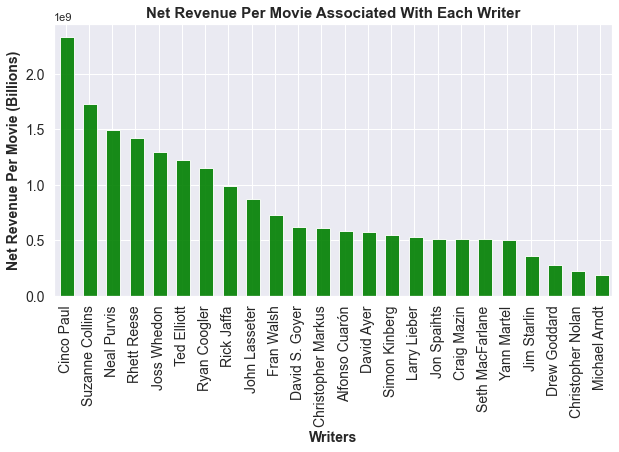

In [50]:
#Bar plot of the Ratio of net revenue per movie in the top 100 movies
writer_ratio.plot(kind='bar',  
                    figsize=(10, 5), 
                    color='Green', 
                    alpha=.9,
                    Width=.6,
                    fontsize=14,
                    x='Writers',
                    y='ratio',
                    legend=False)
plt.title('Net Revenue Per Movie Associated With Each Writer', fontsize=15, fontweight='bold')
plt.xlabel('Writers', fontsize=14, fontweight='bold')
plt.ylabel('Net Revenue Per Movie (Billions)', fontsize=14, fontweight='bold');

We can obtain the same information from this visual as we did the director section but now easily determine the individuals who wrote the most movies in the top 100. Again, it would be recomended to use the work of those individuals who are associated with the highest net revenue per movie they wrote in the top 100 movies. Suggested writers: Cinco Paul, Suzanne Collins, and Neal Purvis.

### Actors in the Top 100 Movies
In this section we repeat the process above except we obtain all the actors in the top 100 movies.

The data preparation here is similar to that which was performed above but the process is slightly differint because we lack a table that is specific to actors. We can obtain the actor information we need by using a table that contains the information on each of the principals involved in the movies. We start by merging the top 100 rated movies with the principals table.

In [42]:
# merge movie principals with top 100 rated movies
top_principals= pd.merge(top_100_movies_pop, principals, how="inner", on='movie_id')
# merge persons with top principals table to get principal names
top_principals = pd.merge(top_principals, persons, how="inner", on='person_id')

We then filter for rows that only contain the principal actor or actress in each movie.

In [43]:
# Filter Data Frame to only select for actors
top_principal_actors = top_principals[(top_principals.category == 'actor') | (top_principals.category == 'actress')]

We can now follow the same procedure as we did before but now with the actor information.

In [44]:
# Drop Duplicate Values
top_principal_actors.drop_duplicates(subset=['movie_id'], inplace=True)
# count of principal actor appearing in top 100 movies and select for top 25
top_pop_actor_counts = top_principal_actors.primary_name.value_counts()
# Merging principals and persons tables to obtain actor information
top_100_princ = pd.merge(top_100_rev, principals, how="inner", on='movie_id')
top_100_actors = pd.merge(top_100_princ, persons, how="inner", on='person_id')
# Count of actors appearing in top 100 movies based on net revenue
top_rev_actor_counts = top_100_actors.primary_name.value_counts()
top_rev_actor_counts.sort_values(ascending=False)
#Create dataframe of count results in top 100 rated movies and top 100 movies based on net revenue
top_rev_actors_df = top_rev_actor_counts.to_frame()
top_pop_actors_df = top_pop_actor_counts.to_frame()
# Merge both dataframes together
top_actor_counts = pd.merge(top_pop_actors_df, top_rev_actors_df, how="outer", left_index=True, right_index=True)
#Change all null values to zero
top_actor_counts = top_actor_counts.fillna(0)
# Reset Index for easier plotting
top_actor_counts.reset_index(inplace=True)
#Rename columns to more clearly represent data
top_actor_counts.rename(columns= {'index': 'Actors', 'primary_name_x' :'Top 100 Movies Based on Rating', 'primary_name_y' :'Top 100 Movies Based on Net Revenue'}, inplace=True)
#Sort Values in descending order
top_actor_counts.sort_values(by=['Top 100 Movies Based on Rating'] , ascending=False, inplace=True)
# Net Revenue of top 100 movies grouped by actor
top_actor_groupby = top_100_actors.groupby('primary_name').sum().sort_values(by='net_revenue', ascending=False)
#select top 25 results to plot
top_actor_groupby = top_actor_groupby.net_revenue

<ipython-input-44-57a84d542346>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_principal_actors.drop_duplicates(subset=['movie_id'], inplace=True)


In [45]:
top_actors = top_actor_groupby.to_frame()
top_actors['ratio'] = 0
top_actors.reset_index(inplace=True)
top_actors = top_actors.rename(columns={'primary_name': 'Actors'})
actor_ratio = pd.merge(top_actors, top_actor_counts, how='inner', on='Actors')

In [46]:
#Ratio of net revenue per movie in the top 100 movies
actor_ratio.ratio = actor_ratio.net_revenue/actor_ratio['Top 100 Movies Based on Rating']
# Sorting in descending order
actor_ratio.sort_values(by='ratio', inplace=True, ascending = False)
# Selecting for top 25
actor_ratio = actor_ratio

In [47]:
actor_ratio = actor_ratio[actor_ratio['Top 100 Movies Based on Rating'] != 0]

### Number Of Times Actors Appear in the Top 100 Movies

We can now perform the same visualizations as we did prior but now with actors.

C:\Users\chrchristensen\Anaconda3\envs\learn-env\lib\site-packages\pandas\plotting\_matplotlib\core.py:1373: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  return ax.bar(x, y, w, bottom=start, log=log, **kwds)


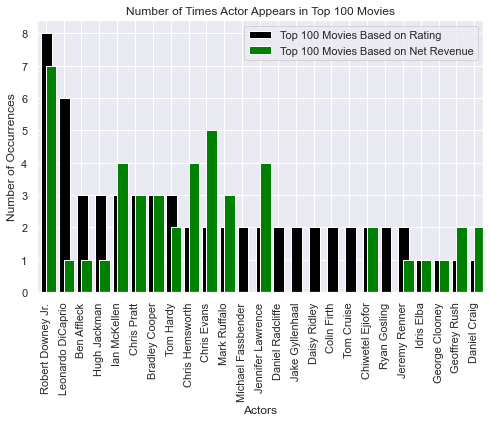

In [48]:
#Plot the count of revenue and rating for each actor in top 100 movies
top_actor_counts.iloc[:25].plot(kind='bar', 
                       x='Actors', 
                       title='Number of Times Actor Appears in Top 100 Movies', 
                       color = ['Black','Green'],
                       alpha=1,
                       figsize=(8, 5),
                       Width=.6,
                       ylabel='Number of Occurrences',
                       xlabel='Actors');

We can obtain the same information from this visual as we did from the previous sections but now for the actors. Again, we would recomend to using the the principal actors that appear on this least when at all possible. Ideally choosing those that appear in both the top 100 rated movies and the top 100 movies based on net revenue.

### Net Revenue  Per Movie Associated with Each Actor

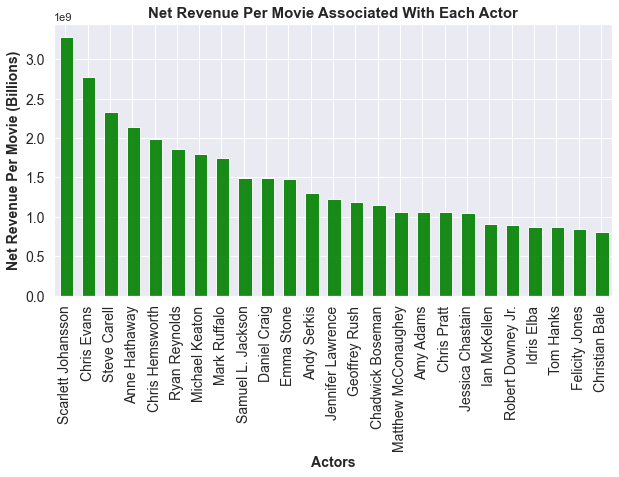

In [49]:
#Bar plot of the Ratio of net revenue per movie in the top 100 movies
actor_ratio[:25].plot(kind='bar',  
                    figsize=(10, 5), 
                    color='Green', 
                    alpha=.9,
                    Width=.6,
                    fontsize=14,
                    x='Actors',
                    y='ratio',
                    legend=False)
plt.title('Net Revenue Per Movie Associated With Each Actor', fontsize=15, fontweight='bold')
plt.xlabel('Actors', fontsize=14, fontweight='bold')
plt.ylabel('Net Revenue Per Movie (Billions)', fontsize=14, fontweight='bold');

Our top Suggested actors are: Scarlet Johansson, Chris Evans, and Steve Carrel.

### Conclusion for Recommendation #3:
When choosing the principal directors, writers, and actors for film production; we recomend that Computing Vision chooses principals that are associated with a high net revenue per movie in the top 100 movies.

## Summary

Our recommendations for Computing Vision's new movie studio are as follows:

1. Focus on genres outside of History, Sports, Western, and Music/Musical
2. Keep run time between 118-130 minutes
3. Select pricipals that have a high net revenue per movie in the top 100.

These recommendations are based on the analysis of IMDB and ‘The Numbers’. We believe these recommendations will help lead Computing Visions to have a successful movie studio through revenue and brand reputation.